# Reservoir Development in Central Basin 

https://github.com/oaimtiaz/Reservoir-development-simulation
https://colab.research.google.com/drive/1gXXuH30RecxkO75t2g_PEfxhpHaFo5q9?usp=sharing 

#### This project aims to automate the process of detecting operational changes in the Central Basin region.

In order to achieve this, a pix2pix model was trained on a number of satellite images from Google Maps to generate a binary map. Then, they were clustered using Density-Based Spatial Clustering of Applications with Noise (DBSCAN) clustering in order to convert the binary maps into distinct wells. 

DBSCAN clustering is an unsupervised machine learning technique that interprets the spatial density of ordered pairs in order to make assessments as to which data belongs to which groups. This type of clustering is particularly useful to us since the pixels in the binary map denoting a well will be clustered spatially.

The pix2pix model works by taking in an image from one domain (Domain A) and converting it to the second domain (Domain B). This image-to-image translation process requires labelled training data to take place. 

## Imports

This project uses a number of imports to facilitate the overall project. Additionally, it makes use of the Python Imaging Library (PIL) and NumPy in order to perform many calculations and interpretations. Furthermore, this workflow uses DBSCAN clustering as implemented by Scikit Learn (sklearn)

In [1]:
from glob import glob
from os.path import splitext
from os import mkdir, getcwd
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import json
import os
from sklearn import mixture
from sklearn.cluster import DBSCAN

Due to hardware constraints, this workflow was originally developed to be run in Google Colab. This requires all persistent storage to take place in a persistent Google storage environment. In this case, this took place in Google Drive.

In [ ]:
from google.colab import drive
import shutil

In [3]:
# Fetch the model from Github (needing to do this each run is a product of worspace used)
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2443, done.
remote: Total 2443 (delta 0), reused 0 (delta 0), pack-reused 2443
Receiving objects: 100% (2443/2443), 8.13 MiB | 13.76 MiB/s, done.
Resolving deltas: 100% (1570/1570), done.


### Change directories and prepair data for training

In [4]:

os.chdir('pytorch-CycleGAN-and-pix2pix/') # move working directory to the pix2pix model

In [5]:
!pip install -r requirements.txt

     |████████████████████████████████| 676 kB 13.2 MB/s 
     |████████████████████████████████| 1.7 MB 48.3 MB/s 
     |████████████████████████████████| 52 kB 1.8 MB/s 
     |████████████████████████████████| 140 kB 79.1 MB/s 
     |████████████████████████████████| 180 kB 79.9 MB/s 
     |████████████████████████████████| 97 kB 8.5 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-py3-none-any.whl size=655250 sha256=c5ac5d52bcf54055ea7d6589068ada7e2d398385bd07c5d4f8d7c56153dfed17
  Stored in directory: /root/.cache/pip/wheels/2d/d1/9b/cde923274eac9cbb6ff0d8c7c72fe30a3da9095a38fd50bbf1
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=9e970ad16e52316dfd9f15375273344c4cd17c62ec21d9a8a4edb073209d3e4e
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl

In [6]:
# This is necessary to access Google Drive from Colab
drive.mount('/content/drive')

Mounted at /content/drive


## Data Labelling and Usage

The training data in this project were labelled using Label Studio. Then, the binary map was exported as a raw numpy array, as well as in JSON format. Given the output format of the data from Label Studio, it is necessary to map the input images to the associated JSON file, and then to the numpy array. 

In [7]:
train_images = glob('/content/drive/MyDrive/data/paired_chunks/*.jpg') # glob("../data/train/*.jpg")

In [8]:
train_labels = glob('/content/drive/MyDrive/data/labels/*.npy')

In [9]:
train_json = None
with open('/content/drive/MyDrive/data/well_maps.json') as well_json:
  train_json = json.load(well_json)

In [10]:
mappings = {}

In [11]:
# get data from the json file
for j in train_json:
  im_name = j['file_upload'].split('-')[1]
  im_id = j['id']
  label = train_labels[0]
  for l in train_labels:
    if f"task-{im_id}" in l:
      label = l
      break
  im = train_images[0]
  for i in train_images:
    if im_name in i:
      im = i
      break
  mappings[im] = label

In [12]:
def get_mapping(image_num):
  return train_images[image_num], mappings[train_images[image_num]]

In [15]:
def stack_image(image_num):
  original, labeled = get_mapping(image_num)
  original = np.array(Image.open(original))
  labeled = np.load(labeled)
  output = np.hstack([original, labeled])
  output = np.uint8((output / np.amax(output)) * 255)
  return output

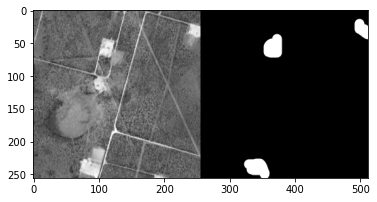

In [16]:
plt.imshow(stack_image(0), cmap='gray')

Each image was then saved to Google Drive to provide a persistent location for this data

In [ ]:
for i in tqdm(range(len(train_images))):
  im = Image.fromarray(stack_image(i), 'L')
  if i % 5 == 1:
    im.save(f'/content/drive/MyDrive/data/wells_stacked/test/{i}.png')
  else:
    im.save(f'/content/drive/MyDrive/data/wells_stacked/train/{i}.png')

  0%|          | 0/25 [00:00<?, ?it/s]

# Training

The training was performed over 200 epochs on a GPU. The input and output images had one channel each. 

In [ ]:
!python train.py --dataroot /content/drive/MyDrive/data/wells_stacked --name im2map --model pix2pix --direction AtoB --gpu_ids 0 --input_nc 1 --output_nc 1 --num_threads 2 --display_id 0

In [ ]:
chk_dir = "/content/drive/MyDrive/data/model checkpoints/"

In [ ]:
shutil.copytree('checkpoints/im2map/', chk_dir)

The following section is for retrieval of the model weights from persistent google drive storage. This is only necessary when operating in Colab, the weights were previously saved, and the model is being used in a different runtime

In [ ]:
shutil.copytree(chk_dir, 'checkpoints')

'checkpoints'

# Usage

Once the model is trained, you can use the model by specifying the directory as needed and running the test.py script. This will generate output images in the results directory. 


In [ ]:
!python test.py --dataroot /content/drive/MyDrive/data/wells_stacked/ --name im2map --model pix2pix --input_nc 1 --output_nc 1 --gpu_ids -1

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/data/wells_stacked/	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: -1                            	[default: 0]
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 1                             	[default: 3]
                  isTrain: False                         	[default: None]
                lo

In [ ]:
result_dir = 'results/im2map/test_latest/images/*_fake_B.png'
im_dirs = glob(result_dir)

## Post processing with DBSCAN to count wells

Once the images have been translated into a binary map by the pix2pix model, they can be used by accessing the results from the results directory. 

We then compared these results to the input training labels. The interpretation was also done by visually comparing how many wells appeared to be in an image to how many the model identified.

In [ ]:
def get_num_wells(im):
  threshold = 255//2.5
  well_locs = np.array(np.where(im > threshold)).T
  scan = DBSCAN(eps=1)
  res = scan.fit_predict(well_locs)
  return res, len(np.unique(res))-1

## Visualizing predictions

This section visualizes the predictions of the model and prints the result.

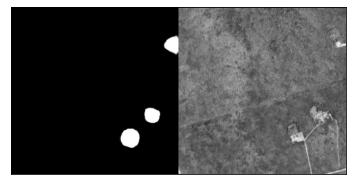

Image #11: Predicted # wells = 3


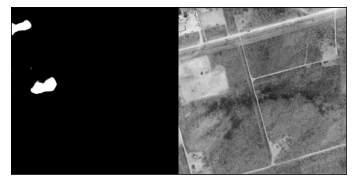

Image #6: Predicted # wells = 2


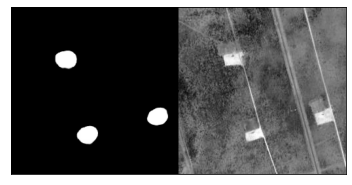

Image #21: Predicted # wells = 3


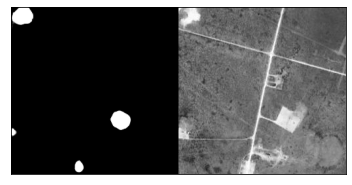

Image #1: Predicted # wells = 4


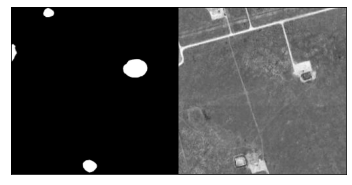

Image #16: Predicted # wells = 4


In [ ]:
for im in im_dirs:
  i = np.mean(np.array(Image.open(im)), axis=2)
  l, n = get_num_wells(i)
  im_num = im.split('/')[-1].split('_')[0]
  original = f"/content/drive/MyDrive/data/wells_stacked/test/{im_num}.png"
  original = np.array(Image.open(original))
  original = original[:,:original.shape[1]//2]
  s = np.hstack([i, original])
  plt.imshow(s, cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.show()
  print(f"Image #{im_num}: Predicted # wells = {n}")

## Analyzing Results

The Pix2Pix binary map was then clustered and used to be compared against the training map's clustering. This was used to calculate the MSE of the data.

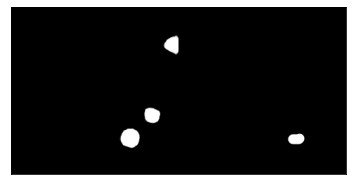

Image #11: Predicted # wells = 3 Actual # wells = 0


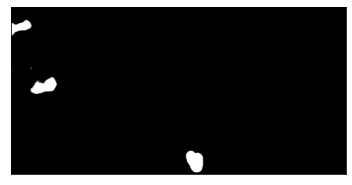

Image #6: Predicted # wells = 2 Actual # wells = 0


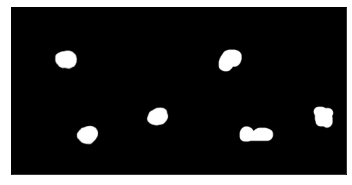

Image #21: Predicted # wells = 3 Actual # wells = 2


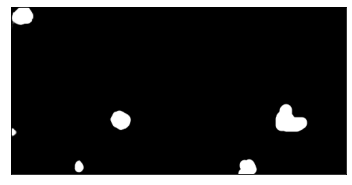

Image #1: Predicted # wells = 4 Actual # wells = 2


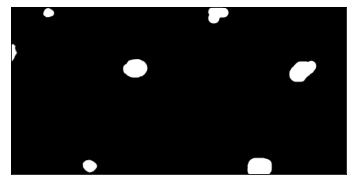

Image #16: Predicted # wells = 4 Actual # wells = 3


In [ ]:
mse = 0
for im in im_dirs:
  i = np.mean(np.array(Image.open(im)), axis=2)
  l, n_pred = get_num_wells(i)
  im_num = im.split('/')[-1].split('_')[0]
  original = f"/content/drive/MyDrive/data/wells_stacked/test/{im_num}.png"
  original = np.array(Image.open(original))
  original = original[:,original.shape[1]//2:]
  l, n_act = get_num_wells(original)
  s = np.hstack([i, original])
  plt.imshow(s, cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.show()
  print(f"Image #{im_num}: Predicted # wells = {n_pred} Actual # wells = {n_act}")
  mse += (n_act - n_pred) **2
mse /= len(im_dirs)

### Resultant mean squared error loss of the model

In [ ]:
print(f"MSE: {mse}")

MSE: 3.8


# Interpretation of Results

The results seem to indicate overall good performance, however it is not perfect. In particular, it performs significantly better on the training data than on the testing data, indicating it might be overfit. This can also be seen in that the model appears to be overly aggressive with labeling results as wells. Overall, the model rarely is off by more than one well, but can be off by significantly more. The model appears to be mostly incorrectly labelling other human structures as wells, so this model would most likely perform better in a less developed environment or require further training with better-labelled data.